In [1]:
import shap
from Bio import AlignIO
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split

import seaborn as sns

SEED=25

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# Extracting sequences as multiple alignments into a numpy array 
alignment = AlignIO.read('aligned ireds.clustal', 'clustal')
align_array = np.array([list(rec) for rec in alignment], np.dtype(np.str_))
print('Array shape %i by %i' % align_array.shape)

Array shape 383 by 1000


In [6]:
# Extracting IRED number from alignments, ready to assign to index in dataframe
align_index = AlignIO.read('aligned ireds.clustal', 'clustal')
ired_names = []
for record in align_index:
    ired_names.append(record.id)

In [7]:
# Creating a dictionary of the z5 metrics plus another dimension (binary) which distinguishes between AA and gaps
z5_dict = {
    'A': [0.24, -2.32, 0.60, -0.14, 1.30],
    'R': [3.52, 2.50, -3.50, 1.99, -0.17],
    'N': [3.05, 1.62, 1.04, -1.15, 1.61],
    'D': [3.98, 0.93, 1.93, -2.46, 0.75],
    'C': [0.84, -1.67, 3.71, 0.18, -2.65],
    'Q': [1.75, 0.50, -1.44, -1.34, 0.66],
    'E': [3.11, 0.26, -0.11, -3.04, -0.25],
    'G': [2.05, -4.06, 0.36, -0.82, -0.38],
    'H': [2.47, 1.95, 0.26, 3.90, 0.09],
    'I': [-3.89, -1.73, -1.71, -0.84, 0.26],
    'L': [-4.28, -1.30, -1.49, -0.72, 0.84],
    'K': [2.29, 0.89, -2.49, 1.49, 0.31],
    'M': [-2.85, -0.22, 0.47, 1.94, -0.98],
    'F': [-4.22, 1.94, 1.06, 0.54, -0.62],
    'P': [-1.66, 0.27, 1.84, 0.70, 2.00],
    'S': [2.39, -1.07, 1.15, -1.39, 0.67],
    'T': [0.75, -2.18, -1.12, -1.46, -0.40],
    'W': [-4.36, 3.94, 0.59, 3.44, -1.59],
    'Y': [-2.54, 2.44, 0.43, 0.04, -1.47],
    'V': [-2.59, -2.64, -1.54, -0.85, -0.02],
    '-': [0.0, 0.0, 0.0, 0.0, 0.0],
    '*': [0.0, 0.0, 0.0, 0.0, 0.0]
}

In [8]:
# Creating a dictionary of all (active and non-active) IRED enzymes and their featurised sequences
feat_seqs = {}
for i, sequence in enumerate(align_array):
    single_feat = []
    for aa in sequence:
        indices = z5_dict.get(aa)
        single_feat.extend(indices)
    feat_seqs[ired_names[i]] = single_feat

In [9]:
# Reading in the excel file of the data and dropping inactive entries 
df_ee = pd.read_excel('Prelim data.xlsx', engine='openpyxl')
df_ee.dropna(subset=['Enantiomer'], inplace=True)
df_ee.head(2)
df_ee.shape

(206, 6)

In [10]:
# Creating a dictionary for the enantiomer data extracted from the excel file above
labels = {}
for index, row in df_ee.iterrows():
    labels[str(row['IRED No. '])] = row['enantiomer binary']

In [11]:
enantiomer_list = []
descrip_list = []
for ired_name in labels:
    enantiomer_list.append(labels.get(ired_name))
    descrip_list.append(feat_seqs.get(ired_name))

In [12]:
X = descrip_list
y = enantiomer_list 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=SEED)

[09:32:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


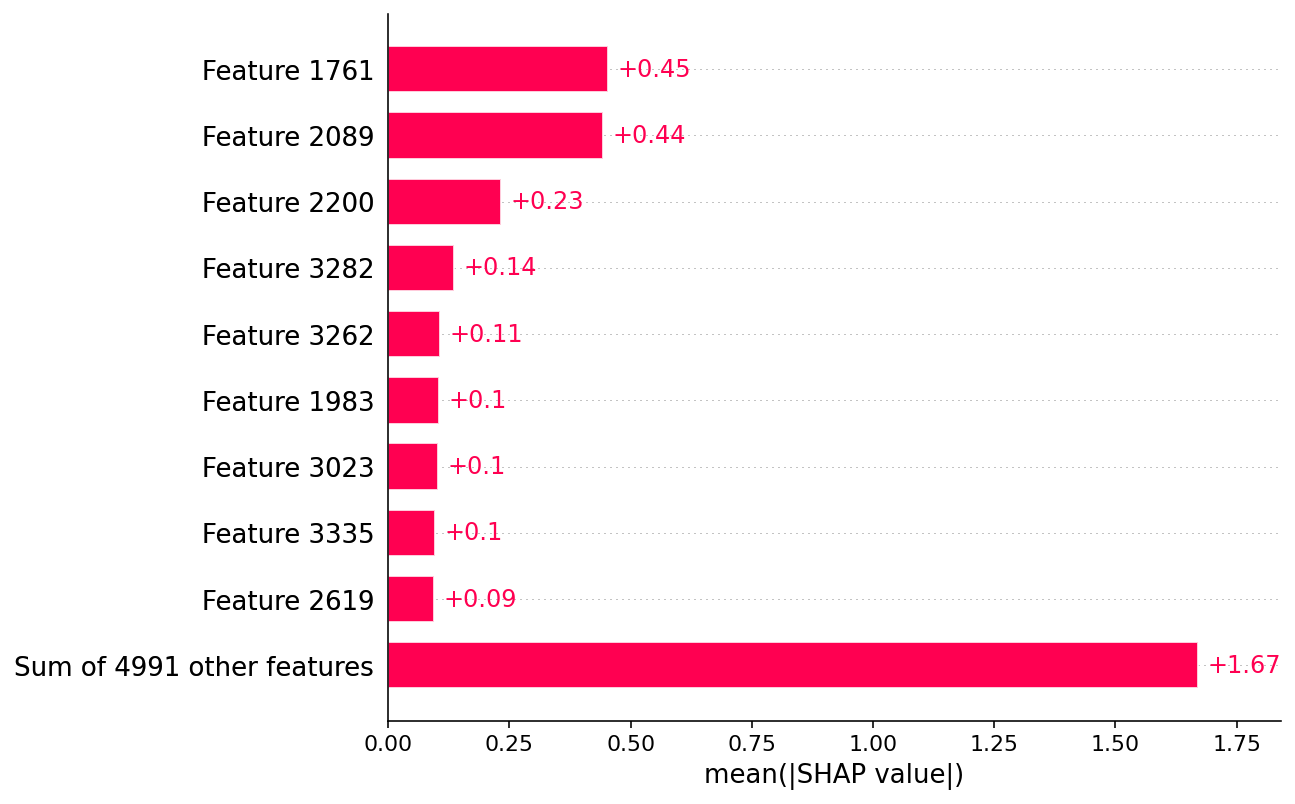

In [14]:
# Getting data into correct format for fitting XGBoost model
X_trainNPArray = np.array(X_train); X_testNPArray = np.array(X_test)
y_trainNPArray = np.array(y_train); y_testNPArray = np.array(y_test)

X_train_xgb = np.vstack(X_trainNPArray); X_test_xgb = np.vstack(X_testNPArray)
y_train_xgb = np.vstack(y_trainNPArray); y_test_xgb = np.vstack(y_testNPArray)

# Instantiating and fitting the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=SEED, use_label_encoder=False)
xgb_model.fit(X_train_xgb, y_train_xgb)

XNPArray = np.array(X); X_xgb = np.vstack(XNPArray)
# Explaining the model's predictions using SHAPs explainer function
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_xgb)

# Visualising the predictor's explanation with a bar plot of ascending importance (fingers crossed...)
ax = shap.plots.bar(shap_values)

In [15]:
features = [1761, 2089, 2200, 3282, 3262, 1983, 3023, 3335, 2619]
aa = []
for i in features:
    aa.append(i/6)
print(aa)

[293.5, 348.1666666666667, 366.6666666666667, 547.0, 543.6666666666666, 330.5, 503.8333333333333, 555.8333333333334, 436.5]


The plots above indicate that features 2113, 2506, 2640, 3938, 2379, 3914, 3627, 3220 and 4002 are to be followed up on, by extracting the AA they correspond to and finding the frequency of this residue in the 206 active IRED sequences.

In [16]:
# Creating a dictionary to enable the identification and frequency of important AA residues according to CHAP
keyset = list(labels.keys())
aa_dict = {}
for key in keyset:
    for i, sequence in enumerate(align_array):
        if key == str(i):
            aa_dict[key] = sequence

In [17]:
residue_df = pd.DataFrame.from_dict(aa_dict, orient='index')
residue_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [18]:
from collections import Counter

In [19]:
position_293 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_293.append(all_seqs[292])

residue_df['position 293'] = position_293
Counter(position_293)

Counter({'-': 143,
         'A': 5,
         'M': 10,
         'D': 7,
         'P': 6,
         'H': 2,
         'S': 6,
         'T': 9,
         'I': 2,
         'R': 2,
         'N': 3,
         'L': 2,
         'E': 4,
         'K': 1,
         'V': 2,
         'C': 1})

In [20]:
position_348 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_348.append(all_seqs[348])

residue_df['position 348'] = position_348
Counter(position_348)

Counter({'D': 12,
         'G': 15,
         'P': 64,
         'E': 27,
         'A': 52,
         'S': 8,
         'H': 2,
         'N': 1,
         'T': 6,
         'Y': 1,
         'Q': 6,
         'V': 3,
         'K': 4,
         '-': 2,
         'R': 2})

In [21]:
position_366 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_366.append(all_seqs[365])

residue_df['position 366'] = position_366 
Counter(position_366)

Counter({'-': 201, 'R': 1, 'T': 1, 'K': 1, 'Q': 1})

In [22]:
position_547 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_547.append(all_seqs[546])
    
residue_df['position 547'] = position_547
Counter(position_547)

Counter({'T': 45,
         'D': 4,
         'V': 53,
         'Y': 4,
         'F': 3,
         'L': 45,
         'A': 18,
         'E': 2,
         'W': 1,
         'Q': 2,
         'S': 2,
         'I': 18,
         'M': 3,
         'R': 1,
         '-': 1,
         'H': 2,
         'P': 1})

In [23]:
position_543 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_543.append(all_seqs[542])

residue_df['position 543'] = position_543  
Counter(position_543)

Counter({'-': 201, 'R': 1, 'A': 1, 'G': 2})

In [24]:
position_330 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_330.append(all_seqs[329])
    
residue_df['position 330'] = position_330
Counter(position_330)

Counter({'T': 67,
         'P': 1,
         'V': 92,
         'L': 37,
         'I': 3,
         'M': 1,
         'A': 2,
         'R': 1,
         'C': 1})

In [25]:
position_503 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_503.append(all_seqs[502])
    
residue_df['position 503'] = position_503
Counter(position_503)

Counter({'G': 131, 'A': 62, 'S': 3, 'C': 5, 'V': 2, 'I': 1, 'M': 1})

In [26]:
position_555 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_555.append(all_seqs[554])

residue_df['position 555'] = position_555
Counter(position_555)

Counter({'-': 204, 'P': 1})

In [27]:
position_436 = []
for key in aa_dict.keys():
    all_seqs = aa_dict[key]
    position_436.append(all_seqs[435])
    
residue_df['position 436'] = position_436
Counter(position_436)

Counter({'V': 140, 'I': 51, 'L': 7, 'A': 6, 'F': 1})

In [93]:
residue_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,998,999,position 352,position 417,position 440,position 396,position 652,position 604,position 536,position 667
1,-,-,-,-,-,-,-,-,-,-,...,-,-,E,-,N,V,-,S,K,M
2,-,-,-,-,-,-,-,-,-,-,...,-,-,P,E,T,L,-,Y,E,D


In [96]:
residue_df = residue_df[['position 293', 'position 348', 'position 366', 'position 547', 'position 543', 
                         'position 330', 'position 503', 'position 555', 'position 436']]

In [28]:
residue_df

,0,1,2,3,4,5,6,7,8,9,...,999,position 293,position 348,position 366,position 547,position 543,position 330,position 503,position 555,position 436
1,-,-,-,-,-,-,-,-,-,-,...,-,-,D,-,T,-,T,G,-,V
2,-,-,-,-,-,-,-,-,-,-,...,-,-,G,-,T,-,P,G,-,V
3,-,-,-,-,-,-,-,-,-,-,...,-,A,P,-,D,-,T,G,-,V
4,-,-,-,-,-,-,-,-,-,-,...,-,-,P,-,V,-,T,G,-,V
6,-,-,-,-,-,-,-,-,-,-,...,-,-,E,-,Y,-,V,G,-,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,-,-,-,-,-,-,-,-,-,-,...,-,-,A,-,I,-,V,A,-,V
373,-,-,-,-,-,-,-,-,-,-,...,-,-,A,-,A,-,V,A,-,V
374,-,-,-,-,-,-,-,-,-,-,...,-,-,Q,-,V,-,V,A,-,V
377,-,-,-,-,-,-,-,-,-,-,...,-,-,K,-,V,-,V,A,-,V


In [29]:
df = pd.read_excel('Prelim data.xlsx', engine='openpyxl')
df.dropna(subset=['enantiomer binary'], inplace=True)
df.set_index('IRED No. ', inplace=True)
df.drop(384, inplace=True)
df.shape

(205, 5)

In [30]:
df.tail()

,Reaction 2,ee,Enantiomer,enantiomer binary,Sequence
IRED No.,,,,,
371,"64% (85% ee, R)",85.0,R,0.0,MTGHHRTPVTVVGLGSMGSALAEAFVDAGHAVTVWNRTPSKAAPLV...
373,"22% (83% ee, R)",83.0,R,0.0,MTSHAEHSAVTVLGLGPMGRALANAFLDAGLRTTVWNRTPGRDREL...
374,"97% (>99% ee, S)",99.0,S,1.0,MSSVSIFGLGAMGTAMAARFLEKNFKVTVWNRTPEKANKLLDKGAS...
377,"8% (>99% ee, S)",99.0,S,1.0,MSEKIAFLGLGNLGYPIAESLINSGFDVTVWNRTASKADPLVKLGA...
382,2% (S),2.0,S,1.0,MLKAGHPTTIWNRSPGKGEDLVARGATRAATPAEAVRAGEVVVVCV...


In [32]:
df['position 293'] = position_293
df['position 348'] = position_348
df['position 366'] = position_366
df['position 547'] = position_547
df['position 543'] = position_543
df['position 330'] = position_330
df['position 503'] = position_503
df['position 555'] = position_555
df['position 436'] = position_436

In [33]:
df.drop(columns='Sequence', inplace=True)

In [34]:
df.head(2)

,Reaction 2,ee,Enantiomer,enantiomer binary,position 293,position 348,position 366,position 547,position 543,position 330,position 503,position 555,position 436
IRED No.,,,,,,,,,,,,,
1,"62% (33% ee, S)",33.0,S,1.0,-,D,-,T,-,T,G,-,V
2,"67% (46% ee, S)",46.0,S,1.0,-,G,-,T,-,P,G,-,V


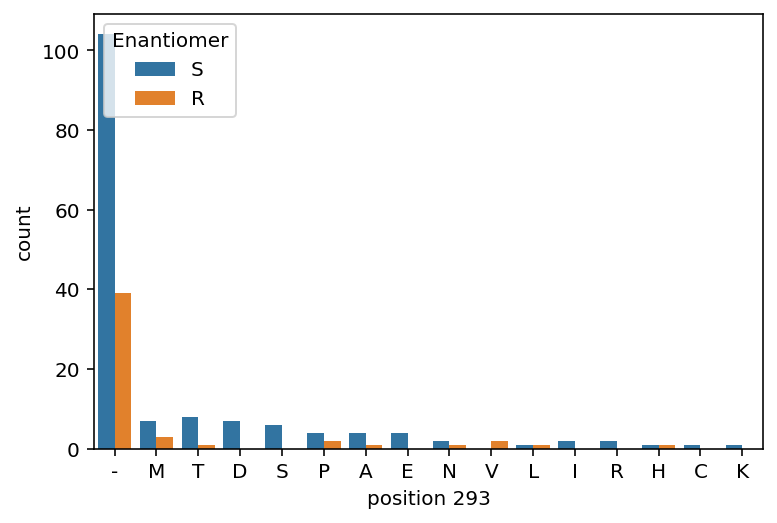

In [35]:
sns_plot = sns.countplot(data=df, x='position 293', hue='Enantiomer', order=df['position 293'].value_counts().index)

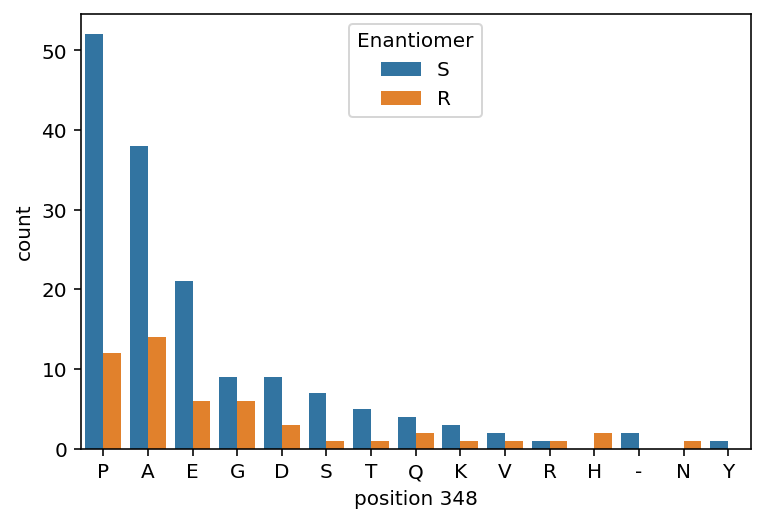

In [36]:
ax = sns.countplot(data=df, x='position 348', hue='Enantiomer', order=df['position 348'].value_counts().index) 

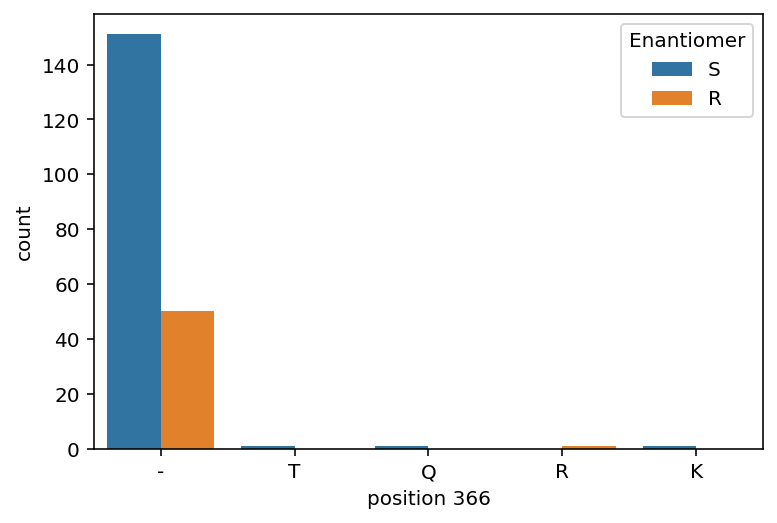

In [37]:
ax = sns.countplot(data=df, x='position 366', hue='Enantiomer', order=df['position 366'].value_counts().index)

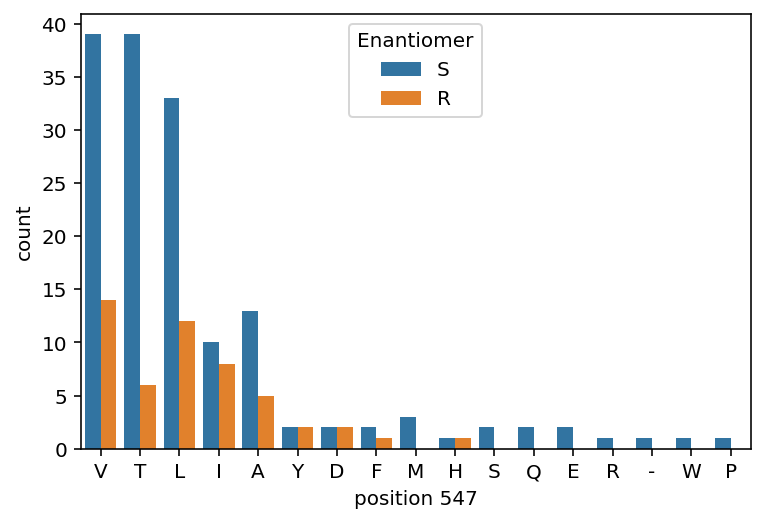

In [39]:
ax = sns.countplot(data=df, x='position 547', hue='Enantiomer', order=df['position 547'].value_counts().index)

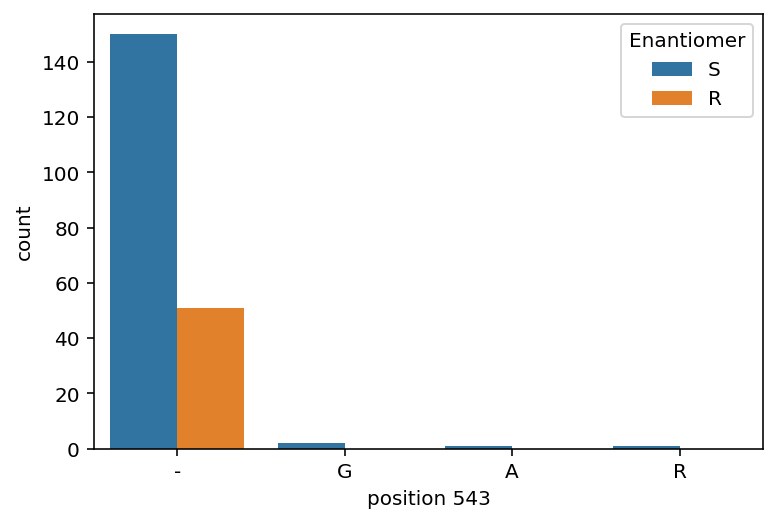

In [40]:
ax = sns.countplot(data=df, x='position 543', hue='Enantiomer', order=df['position 543'].value_counts().index) 

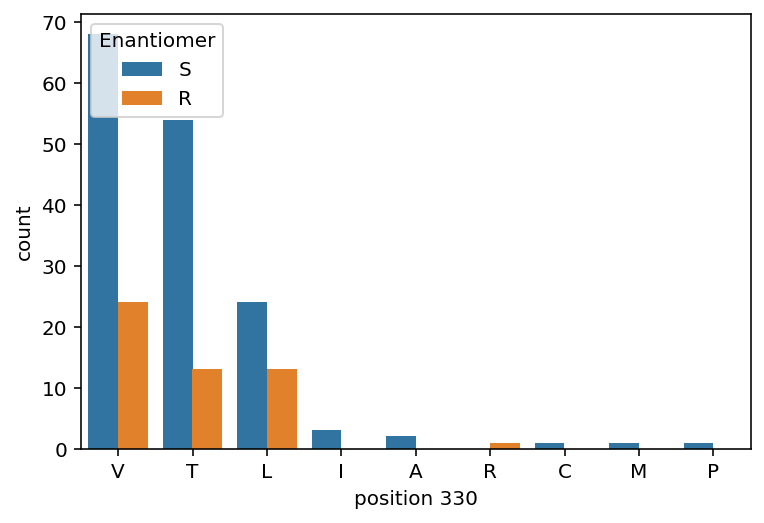

In [41]:
ax = sns.countplot(data=df, x='position 330', hue='Enantiomer', order=df['position 330'].value_counts().index)

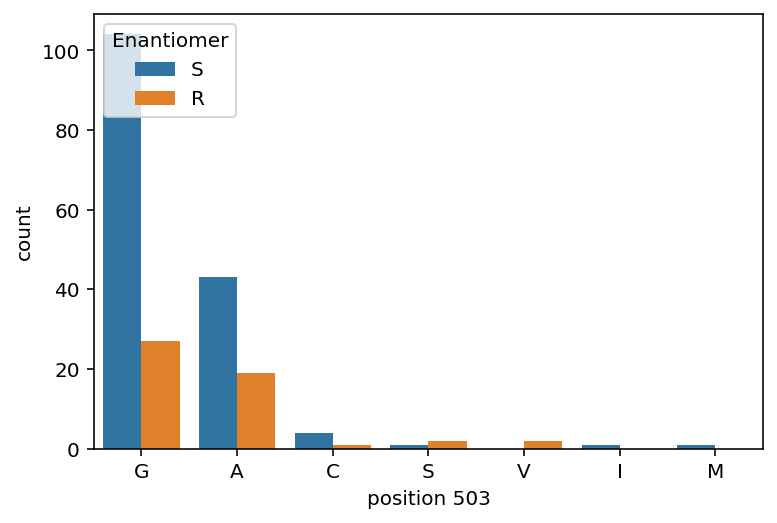

In [42]:
ax = sns.countplot(data=df, x='position 503', hue='Enantiomer', order=df['position 503'].value_counts().index)

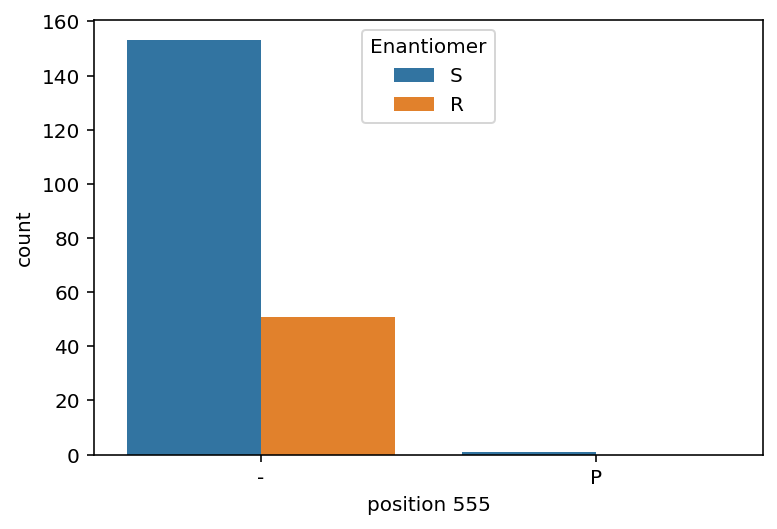

In [43]:
ax = sns.countplot(data=df, x='position 555', hue='Enantiomer', order=df['position 555'].value_counts().index)

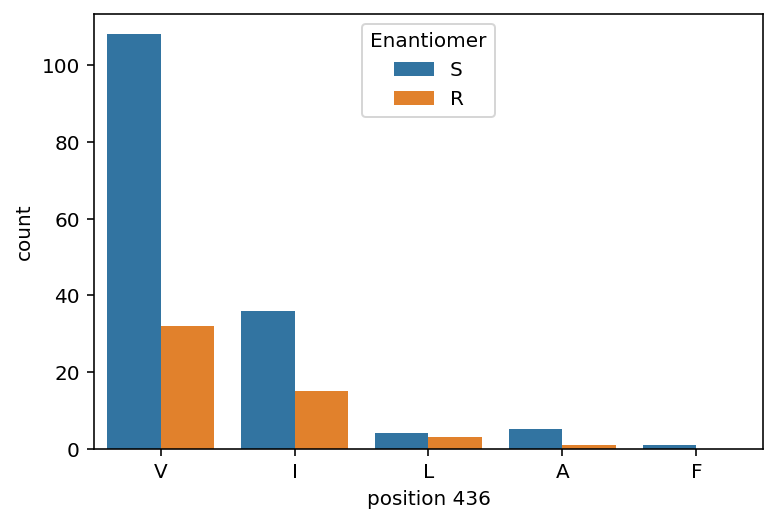

In [45]:
ax = sns.countplot(data=df, x='position 436', hue='Enantiomer', order=df['position 436'].value_counts().index)